In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PLOT_CONFIG,
    save_factory,
    COLORMAPS,
)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from toolz import reduce, merge

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
## arrange data
keep_syllables = np.loadtxt('to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()

In [6]:
## arrange data
## arrange data for females
keep_syllables = np.loadtxt('to_keep_syllables_raw.txt', dtype=int)


female_df = pd.read_parquet('ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [7]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))

m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])
# use the same number of mice per age - only age 80

/tmp/ipykernel_30815/1105121986.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_data['sex'] = 'm'
/tmp/ipykernel_30815/1105121986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['sex'] = 'f'


In [8]:
sort_syllables = m_data.groupby('age', observed=True).mean().quantile(0.95).sort_values(ascending=False).index

In [9]:
df = m_data
# Initialize an empty list to store the bootstrapped data
bootstrapped_data = []

# Number of bootstraps
n_bootstraps = 1000

# Perform the bootstrapping
for i in tqdm(range(n_bootstraps)):
    # Set the random seed for reproducibility
    np.random.seed(i)
    
    # Sample 10 mice for each age
    sampled_df = df.groupby('age').apply(lambda x: x.sample(n=10, replace=True, random_state=i))
    
    # Calculate the average syllable usage per age
    avg_syllable_usage = sampled_df.groupby('age').mean()
    
    # Add the bootstrap index
    avg_syllable_usage['mouse'] = i
    
    # Append the results to the bootstrapped data list
    bootstrapped_data.append(avg_syllable_usage)

# Combine all bootstrapped data into a single dataframe
bootstrapped_df = pd.concat(bootstrapped_data)

# Reset index to have a proper structure
bootstrapped_df.set_index(['mouse'], inplace=True, append=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
df = bootstrapped_df.copy()
n_sylls = 25
roll_size = 6
minp = 3

norms = {}
for mouse, _df in df.groupby('mouse'):
    m_age = _df.index.get_level_values('age')
    smooth_samples = _df[sort_syllables[:n_sylls]].rolling(roll_size, center=True, min_periods=minp).std().mean(1)
    _ages = smooth_samples.index.get_level_values('age').astype(int)
    norms[mouse] = pd.Series(smooth_samples.to_numpy(), index=_ages, name=mouse)
norms = pd.DataFrame(norms)

mask = norms.isna().sum(1) < 10
norms = norms[mask]
mnorms_melt = norms.reset_index().melt(id_vars='age', var_name='mouse', value_name='ar')


In [11]:
df = f_data
# Initialize an empty list to store the bootstrapped data
bootstrapped_data = []

# Number of bootstraps
n_bootstraps = 1000

# Perform the bootstrapping
for i in tqdm(range(n_bootstraps)):
    # Set the random seed for reproducibility
    np.random.seed(i)
    
    # Sample 10 mice for each age
    sampled_df = df.groupby('age').apply(lambda x: x.sample(n=10, replace=True, random_state=i))
    
    # Calculate the average syllable usage per age
    avg_syllable_usage = sampled_df.groupby('age').mean()
    
    # Add the bootstrap index
    avg_syllable_usage['mouse'] = i
    
    # Append the results to the bootstrapped data list
    bootstrapped_data.append(avg_syllable_usage)

# Combine all bootstrapped data into a single dataframe
bootstrapped_df = pd.concat(bootstrapped_data)

# Reset index to have a proper structure
bootstrapped_df.set_index(['mouse'], inplace=True, append=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
df = bootstrapped_df.copy()
n_sylls = 25
roll_size = 6
minp = 3
norms = {}
for mouse, _df in df.groupby('mouse'):
    m_age = _df.index.get_level_values('age')
    smooth_samples = _df[sort_syllables[:n_sylls]].rolling(roll_size, center=True, min_periods=minp).std().mean(1)
    _ages = smooth_samples.index.get_level_values('age').astype(int)
    norms[mouse] = pd.Series(smooth_samples.to_numpy(), index=_ages, name=mouse)
norms = pd.DataFrame(norms)

mask = norms.isna().sum(1) < 10
norms = norms[mask]
fnorms_melt = norms.reset_index().melt(id_vars='age', var_name='mouse', value_name='ar')

In [13]:
format_plots()

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

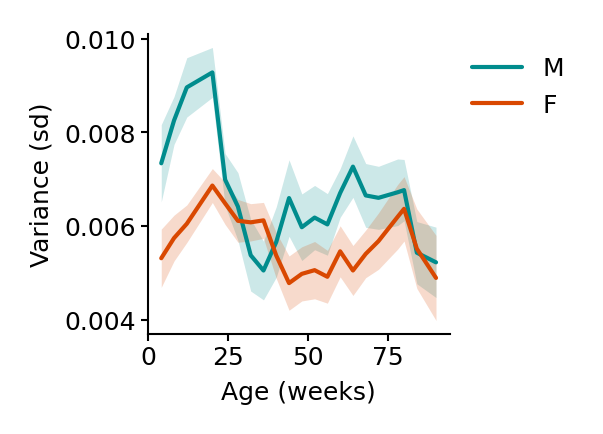

In [14]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(data=mnorms_melt, x='age', y='ar', errorbar='sd', err_kws=dict(lw=0), color=COLORMAPS.ont_male(255), label="M")
sns.lineplot(data=fnorms_melt, x='age', y='ar', errorbar='sd', ax=ax, err_kws=dict(lw=0), color=COLORMAPS.ont_female(255), label="F")
ax.set(ylabel="Variance (sd)", xlabel="Age (weeks)")
legend(ax)
sns.despine()

In [15]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ '07_24_fvm_aging_rate.pdf')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f